In [104]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt

In [69]:
dataset_dir = 'dataset'
sift_dir = 'sift'
matches_dir = 'matches'
salient_matches_dir ="salient_matches"

In [57]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [58]:
imgs = load_images_from_folder(dataset_dir)
kps=[]
dess=[]

In [59]:
def SIFT(img):
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    img_with_sift=cv.drawKeypoints(img,kp,img)
    return img_with_sift, kp, des

In [60]:
for i in range(0, len(imgs)):
    image_sift, kp, des = SIFT(imgs[i])
    kps.append(kp)
    dess.append(des)
    cv.imwrite(os.path.join(sift_dir,f"{i}.jpg"),image_sift)

In [73]:
def feature_matching(img1, img2, kp1, kp2, des1, des2):
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    count_m = 0
    good = []
    for m,n in matches:
        if m.distance < 0.6*n.distance:
            good.append((m,n))
    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       flags = cv.DrawMatchesFlags_DEFAULT)
    img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,**draw_params)
    return img3, good

In [65]:
matched_masks = []
matches = []
for i in range(0, len(imgs)-1):
    for j in range(i+1, len(imgs)):
        img_match, n_matches, matches = feature_matching(imgs[i], imgs[j], kps[i], kps[j], dess[i], dess[j])
        matched_masks.append(img_match)
        cv.imwrite(os.path.join(matches_dir,f"{i}_{j}.jpg"),img_match)

In [74]:
matches =[]
matches_th = 50
for i in range(0, len(imgs)-1):
    for j in range(i+1, len(imgs)):
        img_match, good = feature_matching(imgs[i], imgs[j], kps[i], kps[j], dess[i], dess[j])
        if len(good) > matches_th:
            matches.append({
                "image":img_match,
                "matches":good,
                "source":i,
                "destination":j
            })
            cv.imwrite(os.path.join(salient_matches_dir,f"{i}_{j}.jpg"),img_match)

In [98]:
def fit_hom(match, kps, imgs):
    src_pts = np.float32([ kps[int(match["source"])][m[0].queryIdx].pt for m in match["matches"]]).reshape(-1,1,2)
    dst_pts = np.float32([ kps[int(match["destination"])][m[0].trainIdx].pt for m in match["matches"] ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    return M

In [99]:
graph = np.empty((len(imgs), len(imgs)), dtype=object)
for match in matches:
    graph[int(match["source"]),int(match["destination"])] = fit_hom(match, kps, imgs)
    

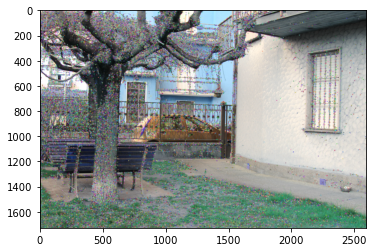

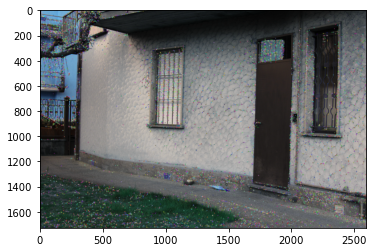

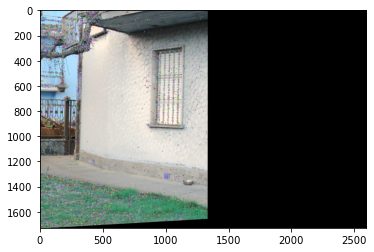

(<matplotlib.image.AxesImage at 0x24220aa8610>, None)

In [124]:
#i think H from img1 to img2
img1 = imgs[2]
img2 = imgs[3]
H = graph[2,3]
size = img2.shape[0:2][::-1]
im_dst = cv2.warpPerspective(img1, H, size)
plt.imshow(img1,),plt.show()
plt.imshow(img2,),plt.show()
plt.imshow(im_dst,),plt.show()

In [121]:
img2.shape[0:2][::-1]

(2592, 1728)